In [5]:
import re
import csv
import sqlite3
from pathlib import Path
import rdkit

from rdkit import Chem, DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import Lipinski
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Crippen
from pathlib import Path
from dbManager import DatabaseManager
import pandas as pd 
import numpy as np

all_data_file = Path('activity_data.csv')

manager = DatabaseManager(database_path='activity_data.db')
manager.drop_all()
manager.create()
manager.populate_compounds_table(all_data_file=all_data_file)
manager.populate_assays_table(all_data_file=all_data_file)


manager.get_conn().commit()

df = pd.read_sql_query("SELECT CID, smiles from compounds", manager.get_conn())


# Cluster by Tanimoto similarity 
Alows for vertical splits of data into train and test sets.  
Pair-wise Tanimoto similarity scores generated, followed by Butina clustering.

In [6]:
# compute fingerprint  
df['fingerprint'] = df.smiles.apply(lambda x : AllChem.GetMorganFingerprint(Chem.MolFromSmiles(x),2))

#Define clustering setup
def ClusterFps(fps,cutoff=0.2):
    from rdkit import DataStructs
    from rdkit.ML.Cluster import Butina

    # first generate the Tanimoto matrix
    dists = []
    nfps = len(fps)
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i],fps[:i])
        dists.extend([1-x for x in sims])

    # now cluster the data:
    cs = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    return cs

# Clustering
Investigating the effect of cutoff on number of clusters generated.
Using Butina clustering.
Will use a cutoff of 0.5 which gives 32 clusters.


[1829, 1381, 917, 609, 398, 269, 144, 44, 7]


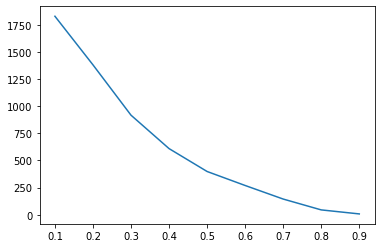

In [7]:
# cutoffs to explore
cutoffs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
cutoff_clusters = []
for cutoff in cutoffs:
    cutoff_clusters.append(ClusterFps(df.fingerprint.tolist(), cutoff=cutoff))
n_clusters = list(len(x) for x in cutoff_clusters)
import matplotlib.pyplot as plt
plt.plot(cutoffs,n_clusters)
print(n_clusters)


A similarity cutoff of 0.4 was selected in order to have sufficient clusters of small enough size to seperate into an 80:20 split.

In [8]:
clusters_0_4 = cutoff_clusters[3]

# determine which cluster each molecule is in 
def find_cluster(clusters, item):
    for i, cluster in enumerate(clusters):
        if item in cluster:
            return i
# write cluster number of pandas df
df['clusters'] =  df.index.map(lambda x : find_cluster(clusters_0_4, x))


# Training split
Use a vertical split to create train and test set using 80/20 split by cluster.
Randomly allocate clusters to test until >20%. 

In [9]:
import random
target_test_size = len(df) * 0.2
test_size = 0
test_clusters = []
cluster_sizes = dict(df.clusters.value_counts())
while test_size < target_test_size:
    random_cluster = random.choice(list(cluster_sizes.keys()))
    size = cluster_sizes.pop(random_cluster)
    test_clusters.append(random_cluster)
    test_size += size
print(test_size, target_test_size)
df['test'] = df.clusters.apply(lambda x: True if x in test_clusters else False)
df.to_pickle('pandas_dumps/compounds_split.pkl')



427 407.40000000000003
